# Space and time

## Surface plots

To represent 3d surfaces in 2d:

- contours with `geom_contour()`
- coloured tiles with `geom_raster()`
- bubble plots with `geom_point()`

use dataset `faithfuld`

In [1]:
library(ggplot2)
library(repr)
options(repr.plot.width=3, repr.plot.height=2, repr.plot.res=180)

# multiplot function from Cookbook for R by Winston Chang
# modified by Yuanxing Cheng
# http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
multiplot <- function(..., plotlist=NULL, file, ncol=1, layout=NULL, res=180) {
    library(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)
    options(repr.plot.width=min(9,3*ncol), repr.plot.height=2*max(numPlots%/%ncol,1), repr.plot.res=res)

    # If layout is NULL, then use 'ncol' to determine layout
    if (is.null(layout)) {
        # Make the panel
        # ncol: Number of columns of plots
        # nrow: Number of rows needed, calculated from # of column
        layout <- matrix(
            seq(1, ncol * ceiling(numPlots/ncol)),
            ncol = ncol, nrow = ceiling(numPlots/ncol),
            byrow=TRUE # set byrow=TRUE will make the subplots listed by row
        )
    }

    if (numPlots==1) {
        print(plots[[1]])
    } else {
        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            # Get the i,j matrix positions of the regions that contain this subplot
            matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
            print(
                plots[[i]],
                vp = viewport(
                    layout.pos.row = matchidx$row,
                    layout.pos.col = matchidx$col
                )
            )
        }
    }
}
myTheme = theme(
    plot.title = element_text(size = rel(0.5)), 
    axis.title = element_text(size = rel(0.8)), 
    legend.title = element_text(size = rel(0.8)))

head(faithfuld)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


eruptions,waiting,density
1.600000,43,0.003216159
1.647297,43,0.003835375
1.694595,43,0.004435548
1.741892,43,0.004977614
1.789189,43,0.005424238
1.836486,43,0.005744544


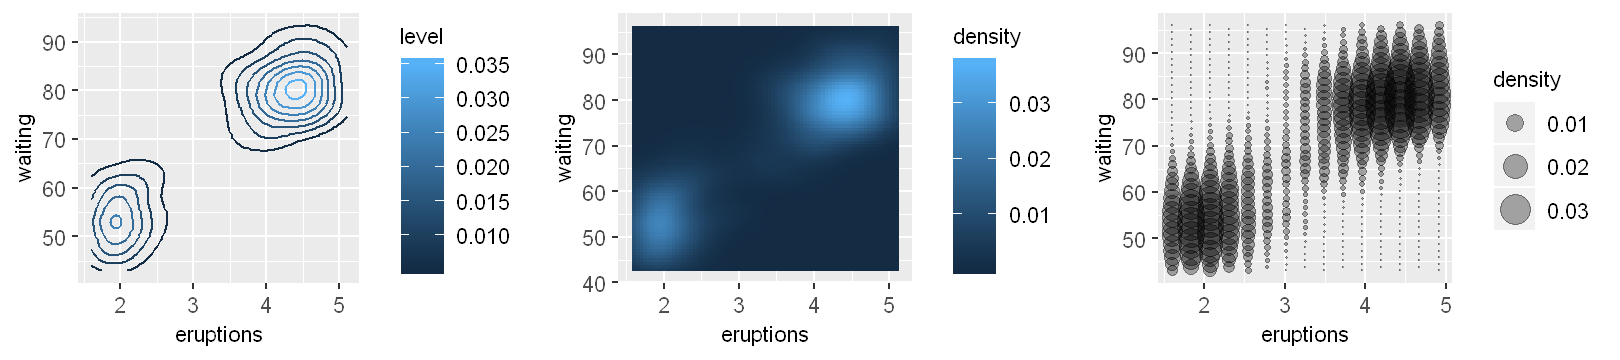

In [2]:
p1 <- ggplot(faithfuld, aes(eruptions, waiting)) + 
geom_contour(aes(z = density, colour = ..level..)) + myTheme
p2 <- ggplot(faithfuld, aes(eruptions, waiting)) + 
geom_raster(aes(fill = density)) + myTheme

small <- faithfuld[seq(1, nrow(faithfuld), by = 10), ]
p3 <- ggplot(small, aes(eruptions, waiting)) + 
geom_point(aes(size = density), alpha = 1/3) + 
scale_size_area() + myTheme

multiplot(p1,p2,p3,ncol=3)

`..level..` means `level` variable computed internally, or the **generated variables**, like `count` and `density`. More in Chap11.6.1

`seq(1, nrow(faithfuld), by = 10)` is to make a smaller dataset since this works better for bubble plot.

## Drawing maps

data to visualise:

- vector boundaries
- point metadata
- area metadata
- raster images

### Vector boundaries

- `lat` for latitude and `long` for longitude
- `group`, a unique identifier for each contiguous region.
- `id`, the name of the region.

`map_data()` requires package `maps`. Operation `%>%` and function `select()` requires package `dplyr`, here I modified the original code, so that you don't need these. See [Cookbook for R](http://www.cookbook-r.com/Manipulating_data/Renaming_columns_in_a_data_frame/) for reference.

lon,lat,group,id
-83.88675,44.85686,1,alcona
-83.36536,44.86832,1,alcona
-83.36536,44.86832,1,alcona
-83.33098,44.83968,1,alcona
-83.30806,44.80530,1,alcona
-83.30233,44.77665,1,alcona


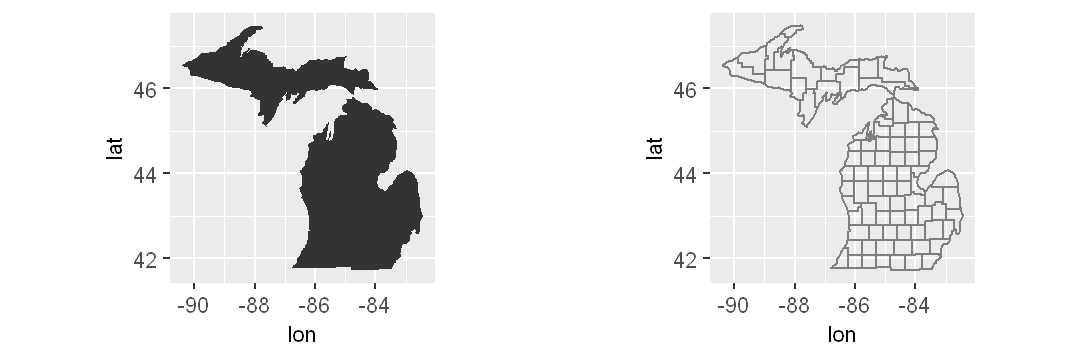

In [3]:
# mi_counties <- map_data("county", "michigan") %>% select(lon = long, lat, group, id = subregion)
mi_counties_raw <- map_data("county", "michigan")
mi_counties <- mi_counties_raw[,c("long","lat","group","subregion")]
names(mi_counties) <- c("lon","lat","group","id")
head(mi_counties)

p1 <- ggplot(mi_counties, aes(lon, lat)) +
geom_polygon(aes(group = group)) + 
coord_quickmap() + myTheme

p2 <- ggplot(mi_counties, aes(lon, lat)) +
geom_polygon(aes(group = group), fill = NA, colour = "grey50") + 
coord_quickmap() + myTheme

multiplot(p1,p2,ncol=2)

`aes(group = group)` is to avoid unnecessary lines between different counties.

`coord_quickmap()` is helpful with adjusting aspect ratio. Just add it.

Other datasets, packages are omitted here.

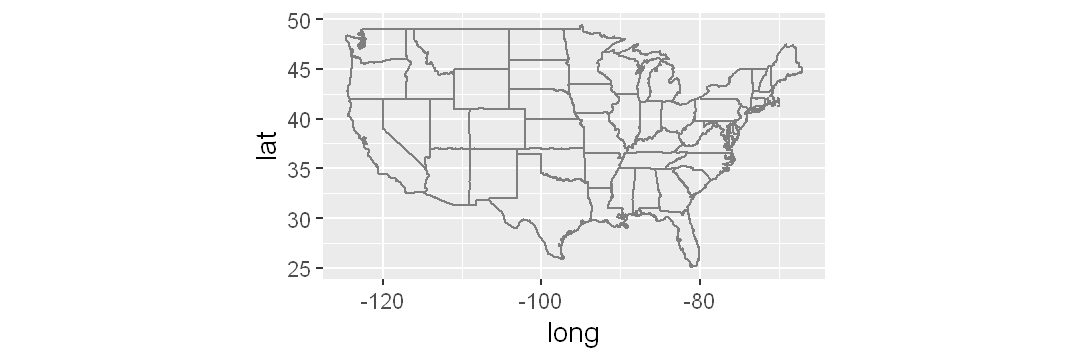

In [4]:
ggplot(map_data("state"), aes(long, lat)) + 
geom_polygon(aes(group = group), colour = "grey50", fill = NA) +
coord_quickmap()

### Point metadata

Use dataset `us.cities`

In [5]:
UScities_raw = us.cities
head(UScities_raw)

name,country.etc,pop,lat,long,capital
Abilene TX,TX,113888,32.45,-99.74,0
Akron OH,OH,206634,41.08,-81.52,0
Alameda CA,CA,70069,37.77,-122.26,0
Albany GA,GA,75510,31.58,-84.18,0
Albany NY,NY,93576,42.67,-73.80,2
Albany OR,OR,45535,44.62,-123.09,0


Note that this `us.cities` is equal to `maps::us.cities`, as in the textbook. `maps::` is like C++, to indicate a specified library. The following code are suggested, and it just needs you to install package `dplyr`. 

```R
mi_cities <- maps::us.cities %>% 
    tbl_df() %>%
    filter(country.etc == "MI") %>%
    select(-country.etc, lon = long) %>%
    arrange(desc(pop))
```

Let's see how to avoid that.

In [6]:
# filg=ter(country.etc == "MI")
UScities_MI_raw = UScities_raw[UScities_raw[,"country.etc"]=="MI",]
head(UScities_MI_raw)

,name,country.etc,pop,lat,long,capital
24,Ann Arbor MI,MI,113716,42.28,-83.73,0
59,Battle Creek MI,MI,54179,42.30,-85.23,0
88,Bloomfield Township MI,MI,43032,42.58,-83.27,0
134,Canton MI,MI,89064,42.31,-83.48,0
187,Clinton MI,MI,100517,42.59,-82.92,0
237,Dearborn Heights MI,MI,55964,42.33,-83.27,0


In [7]:
# select(-country.etc, lon = long)
UScities_MI <- subset(UScities_MI_raw, select = -country.etc)
names(UScities_MI)[names(UScities_MI)=="long"] <- "lon"
# arrange(desc(pop))
UScities_MI <- UScities_MI[with(UScities_MI, order(-pop)), ]
head(UScities_MI)

,name,pop,lat,lon,capital
250,Detroit MI,871789,42.38,-83.10,0
362,Grand Rapids MI,193006,42.96,-85.66,0
950,Warren MI,132537,42.49,-83.03,0
870,Sterling Heights MI,127027,42.58,-83.03,0
485,Lansing MI,117236,42.71,-84.55,2
315,Flint MI,115691,43.02,-83.69,0


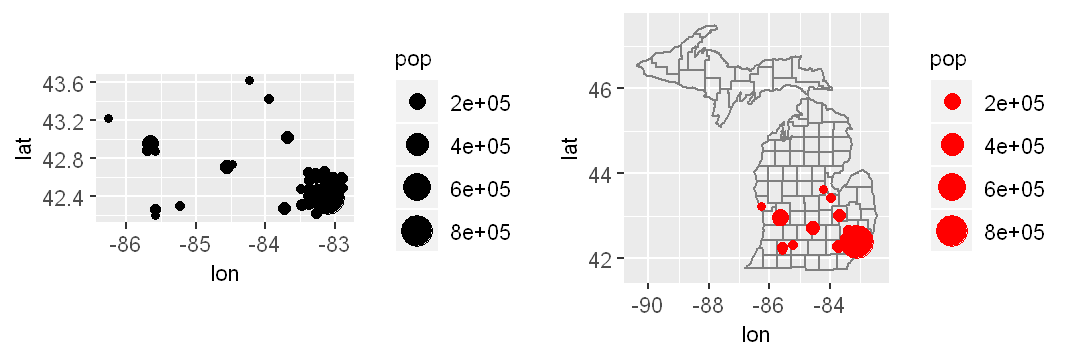

In [8]:
p1 <- ggplot(UScities_MI, aes(lon, lat)) + 
geom_point(aes(size = pop)) + 
scale_size_area() + # add scale
coord_quickmap() + myTheme

p2 <- ggplot(UScities_MI, aes(lon, lat)) + 
geom_polygon(aes(group = group), mi_counties, fill = NA, colour = "grey50") +
geom_point(aes(size = pop), colour = "red") + 
scale_size_area() + 
coord_quickmap() + myTheme

multiplot(p1,p2,ncol=2)

### Raster images

Use `ggmap` package, the textbook use `ggmap::get_openstreetmaps()` which is currently a defunct. Use `get_stamenmap()` instead, with same arguments, see reference from a [Github issue](https://github.com/dkahle/ggmap/issues/172#issuecomment-457926985).

In [9]:
mi_raster <- readRDS("./assets/mi_raster.rds")

In [10]:
if (file.exists("./assets/mi_raster.rds")) {
    mi_raster <- readRDS("./assets/mi_raster.rds")
} else {
    bbox <- c(
        min(mi_counties$lon), min(mi_counties$lat), 
        max(mi_counties$lon), max(mi_counties$lat)
    )
    mi_raster <- ggmap::get_stamenmap(bbox, scale = 8735660)
    saveRDS(mi_raster, "./assets/mi_raster.rds")
}

If you don't like this long warning, add `options(warn=-1)` before that and `options(warn=0)` after that. 

And it takes too much time to plot that so here we draw a smaller one.

144 tiles needed, this may take a while (try a smaller zoom).
Source : http://tile.stamen.com/terrain/10/266/370.png
Source : http://tile.stamen.com/terrain/10/267/370.png
Source : http://tile.stamen.com/terrain/10/268/370.png
Source : http://tile.stamen.com/terrain/10/269/370.png
Source : http://tile.stamen.com/terrain/10/270/370.png
Source : http://tile.stamen.com/terrain/10/271/370.png
Source : http://tile.stamen.com/terrain/10/272/370.png
Source : http://tile.stamen.com/terrain/10/273/370.png
Source : http://tile.stamen.com/terrain/10/274/370.png
Source : http://tile.stamen.com/terrain/10/275/370.png
Source : http://tile.stamen.com/terrain/10/276/370.png
Source : http://tile.stamen.com/terrain/10/277/370.png
Source : http://tile.stamen.com/terrain/10/266/371.png
Source : http://tile.stamen.com/terrain/10/267/371.png
Source : http://tile.stamen.com/terrain/10/268/371.png
Source : http://tile.stamen.com/terrain/10/269/371.png
Source : http://tile.stamen.com/terrain/10/270/371.png
Sou

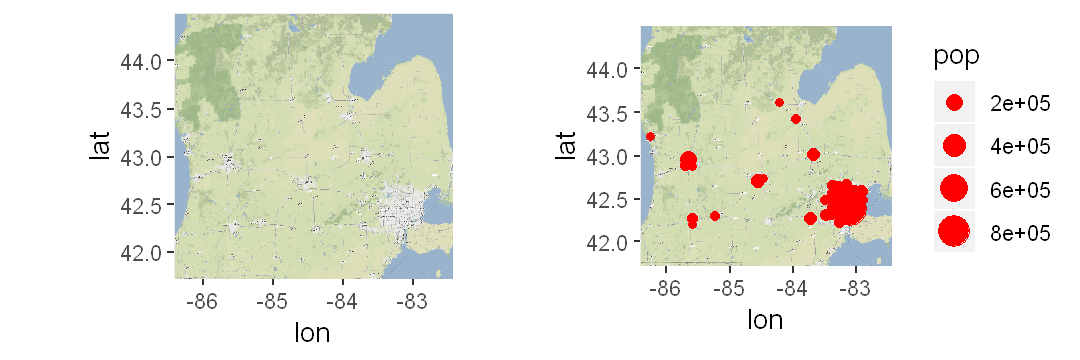

In [11]:
options(warn=-1)
bbox <- c(
        min(mi_counties$lon)+4, min(mi_counties$lat), 
        max(mi_counties$lon), max(mi_counties$lat-3)
    )
    mi_raster <- ggmap::get_stamenmap(bbox, scale = 8735660)

p1 <- ggmap::ggmap(mi_raster)

p2 <- ggmap::ggmap(mi_raster) + 
geom_point(aes(size = pop), UScities_MI, colour = "red") + 
scale_size_area()

multiplot(p1,p2,ncol=2)
options(warn=0)

### Area metadata

Use dataset `midwest` to have required census data.

```R
mi_census <- midwest %>%
    tbl_df() %>%
    filter(state == "MI") %>% 
    mutate(county = tolower(county)) %>%
    select(county, area, poptotal, percwhite, percblack)
```

then combine it with vector boundaries data

```R
census_counties <- left_join(mi_census, mi_counties, by = c("county" = "id"))
```

In [12]:
# filter(state == "MI")
midwest_raw = midwest[midwest[,"state"]=="MI",]
# mutate(county = tolower(county))
midwest_raw["county"] <- eval(parse(text=paste('tempList<-'，tolower(midwest_raw["county"]))))
# select(county, area, poptotal, percwhite, percblack)
mi_census <- midwest_raw[,c("county", "area", "poptotal", "percwhite", "percblack")]
head(mi_census)

county,area,poptotal,percwhite,percblack
alcona,0.041,10145,98.82701,0.26614096
alger,0.051,8972,93.86982,2.37405261
allegan,0.049,90509,95.85787,1.59984090
alpena,0.034,30605,99.23869,0.11436040
antrim,0.031,18185,98.40528,0.12647787
arenac,0.021,14931,98.41940,0.06697475


In [13]:
names(mi_counties)[names(mi_counties)=="id"] <- "county"
# census_counties <- left_join(mi_census, mi_counties, by = c("county" = "id"))
census_counties <- merge(mi_census, mi_counties, by = "county")

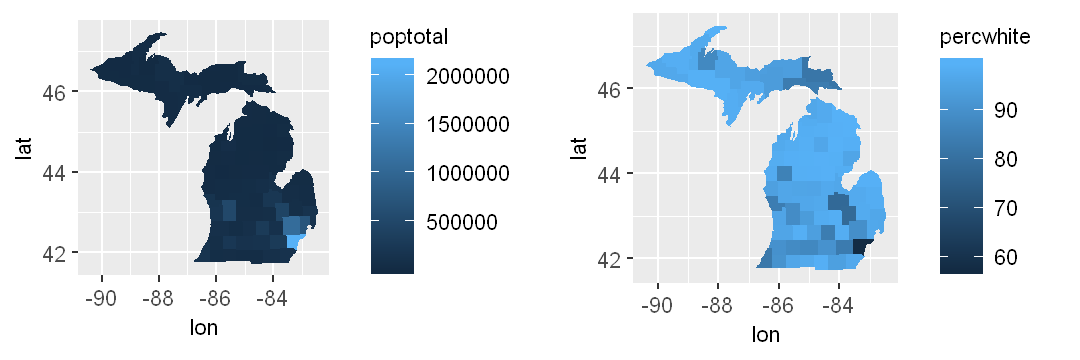

In [14]:
p1 <- ggplot(census_counties, aes(lon, lat, group = county)) + 
geom_polygon(aes(fill = poptotal)) + 
coord_quickmap() + myTheme

p2 <- ggplot(census_counties, aes(lon, lat, group = county)) + 
geom_polygon(aes(fill = percwhite)) + 
coord_quickmap() + myTheme

multiplot(p1,p2,ncol = 2)